# song2Vec

© Yuriy Guts, 2016

Using only the raw text of [A Song of Ice and Fire](https://en.wikipedia.org/wiki/A_Song_of_Ice_and_Fire), we'll derive and explore the semantic properties of its words.

#### Note: Converted to run on Python 3 and gensim-3.4.0


## Imports

In [1]:
import codecs
import glob
import logging
import multiprocessing
import os
import pprint
import re

In [2]:
import nltk
import gensim.models.word2vec as w2v
import sklearn.manifold
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

In [3]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


**Set up logging**

In [4]:
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)

**Download NLTK tokenizer models (only the first time)**

In [5]:
nltk.download("punkt")
nltk.download("stopwords")

[nltk_data] Downloading package punkt to
[nltk_data]     /Users/gabrielmanuelsidik/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/gabrielmanuelsidik/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

## Prepare Corpus

**Load books from files**

In [6]:
book_filenames = sorted(glob.glob("data/*.txt"))

# remove sos.txt
book_filenames = book_filenames[5:]

In [7]:
print("Found books:")
print(book_filenames)


Found books:
['data/sos.txt']


**Combine the books into one string**

In [8]:
corpus_raw = u""
print("corpus_raw", corpus_raw)
for book_filename in book_filenames:
    print("Reading '{0}'...".format(book_filename))
    with codecs.open(book_filename, "r", "utf-8") as book_file:
        corpus_raw += book_file.read()
    print("Corpus is now {0} characters long".format(len(corpus_raw)))
    print()

corpus_raw 
Reading 'data/sos.txt'...
Corpus is now 1151 characters long



**Split the corpus into sentences**

In [9]:
tokenizer = nltk.data.load('tokenizers/punkt/english.pickle')

In [51]:
raw_sentences = tokenizer.tokenize(corpus_raw)
raw_sentences = raw_sentences[0].split("\n")
print(raw_sentences[1])

I've come to talk with you again


In [54]:
#convert into a list of words
#remove unnecessary,, split into words, no hyphens
#list of words

def sentence_to_wordlist(raw):
    clean = re.sub("[^a-zA-Z]"," ", raw)
    words = clean.split()
    return words

In [58]:
#sentence where each word is tokenized
sentences = []
for raw_sentence in raw_sentences:
    print(raw_sentence)
    if len(raw_sentence) > 0:
        sentences.append(sentence_to_wordlist(raw_sentence))
        print(sentences)

Hello darkness, my old friend
[['Hello', 'darkness', 'my', 'old', 'friend']]
I've come to talk with you again
[['Hello', 'darkness', 'my', 'old', 'friend'], ['I', 've', 'come', 'to', 'talk', 'with', 'you', 'again']]
Because a vision softly creeping
[['Hello', 'darkness', 'my', 'old', 'friend'], ['I', 've', 'come', 'to', 'talk', 'with', 'you', 'again'], ['Because', 'a', 'vision', 'softly', 'creeping']]
Left its seeds while I was sleeping
[['Hello', 'darkness', 'my', 'old', 'friend'], ['I', 've', 'come', 'to', 'talk', 'with', 'you', 'again'], ['Because', 'a', 'vision', 'softly', 'creeping'], ['Left', 'its', 'seeds', 'while', 'I', 'was', 'sleeping']]
And the vision that was planted in my brain
[['Hello', 'darkness', 'my', 'old', 'friend'], ['I', 've', 'come', 'to', 'talk', 'with', 'you', 'again'], ['Because', 'a', 'vision', 'softly', 'creeping'], ['Left', 'its', 'seeds', 'while', 'I', 'was', 'sleeping'], ['And', 'the', 'vision', 'that', 'was', 'planted', 'in', 'my', 'brain']]
Still remain

In [59]:
# print(raw_sentence)
# print(sentence_to_wordlist(raw_sentences))

In [61]:
token_count = sum([len(sentence) for sentence in sentences])
print("The song corpus contains {0:,} tokens".format(token_count))

The song corpus contains 218 tokens


## Train Word2Vec

In [102]:
#ONCE we have vectors
#step 3 - build model
#3 main tasks that vectors help with
#DISTANCE, SIMILARITY, RANKING

# Dimensionality of the resulting word vectors.
#more dimensions, more computationally expensive to train
#but also more accurate
#more dimensions = more generalized
num_features = 300
# Minimum word count threshold.
min_word_count = 1

# Number of threads to run in parallel.
#more workers, faster we train
num_workers = multiprocessing.cpu_count()

# Context window length.
context_size = 7

# Downsample setting for frequent words.
#0 - 1e-5 is good for this
downsampling = 1e-3

# Seed for the RNG, to make the results reproducible.
#random number generator
#deterministic, good for debugging
seed = 1

In [176]:
song2vec = w2v.Word2Vec(
    sg=1,
    seed=seed,
    workers=num_workers,
    size=num_features,
    min_count=min_word_count,
    window=context_size,
    sample=downsampling
)

In [177]:
song2vec.build_vocab(sentences)

2018-08-03 13:38:41,897 : INFO : collecting all words and their counts
2018-08-03 13:38:41,899 : INFO : PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
2018-08-03 13:38:41,901 : INFO : collected 131 word types from a corpus of 218 raw words and 34 sentences
2018-08-03 13:38:41,902 : INFO : Loading a fresh vocabulary
2018-08-03 13:38:41,905 : INFO : min_count=1 retains 131 unique words (100% of original 131, drops 0)
2018-08-03 13:38:41,906 : INFO : min_count=1 leaves 218 word corpus (100% of original 218, drops 0)
2018-08-03 13:38:41,908 : INFO : deleting the raw counts dictionary of 131 items
2018-08-03 13:38:41,910 : INFO : sample=0.001 downsamples 131 most-common words
2018-08-03 13:38:41,912 : INFO : downsampling leaves estimated 101 word corpus (46.5% of prior 218)
2018-08-03 13:38:41,914 : INFO : estimated required memory for 131 words and 300 dimensions: 379900 bytes
2018-08-03 13:38:41,915 : INFO : resetting layer weights


In [179]:
print("Word2Vec vocabulary length:", len(song2vec.wv.vocab))

Word2Vec vocabulary length: 131


**Start training, this might take a minute or two...**

In [180]:
song2vec.train(sentences, total_examples=song2vec.corpus_count, epochs=10)

2018-08-03 13:38:49,534 : INFO : training model with 4 workers on 131 vocabulary and 300 features, using sg=1 hs=0 sample=0.001 negative=5 window=7
2018-08-03 13:38:49,540 : INFO : worker thread finished; awaiting finish of 3 more threads
2018-08-03 13:38:49,541 : INFO : worker thread finished; awaiting finish of 2 more threads
2018-08-03 13:38:49,543 : INFO : worker thread finished; awaiting finish of 1 more threads
2018-08-03 13:38:49,544 : INFO : worker thread finished; awaiting finish of 0 more threads
2018-08-03 13:38:49,545 : INFO : EPOCH - 1 : training on 218 raw words (107 effective words) took 0.0s, 21364 effective words/s
2018-08-03 13:38:49,549 : INFO : worker thread finished; awaiting finish of 3 more threads
2018-08-03 13:38:49,552 : INFO : worker thread finished; awaiting finish of 2 more threads
2018-08-03 13:38:49,553 : INFO : worker thread finished; awaiting finish of 1 more threads
2018-08-03 13:38:49,553 : INFO : worker thread finished; awaiting finish of 0 more thre

(1005, 2180)

**Save to file, can be useful later**

In [181]:
if not os.path.exists("trained"):
    os.makedirs("trained")

In [182]:
song2vec.save(os.path.join("trained", "song2vec.w2v"))

2018-08-03 13:38:52,590 : INFO : saving Word2Vec object under trained/song2vec.w2v, separately None
2018-08-03 13:38:52,591 : INFO : not storing attribute vectors_norm
2018-08-03 13:38:52,593 : INFO : not storing attribute cum_table
2018-08-03 13:38:52,600 : INFO : saved trained/song2vec.w2v


## Explore the trained model.

In [183]:
song2vec = w2v.Word2Vec.load(os.path.join("trained", "song2vec.w2v"))

2018-08-03 13:38:54,821 : INFO : loading Word2Vec object from trained/song2vec.w2v
2018-08-03 13:38:54,826 : INFO : loading wv recursively from trained/song2vec.w2v.wv.* with mmap=None
2018-08-03 13:38:54,828 : INFO : setting ignored attribute vectors_norm to None
2018-08-03 13:38:54,830 : INFO : loading vocabulary recursively from trained/song2vec.w2v.vocabulary.* with mmap=None
2018-08-03 13:38:54,833 : INFO : loading trainables recursively from trained/song2vec.w2v.trainables.* with mmap=None
2018-08-03 13:38:54,835 : INFO : setting ignored attribute cum_table to None
2018-08-03 13:38:54,837 : INFO : loaded trained/song2vec.w2v


### Compress the word vectors into 2D space and plot them

In [184]:
#my video - how to visualize a dataset easily
tsne = sklearn.manifold.TSNE(n_components=2, random_state=0)

In [185]:
all_word_vectors_matrix = song2vec.wv.vectors

**Train t-SNE, this could take a minute or two...**

In [186]:
all_word_vectors_matrix_2d = tsne.fit_transform(all_word_vectors_matrix)

/Users/gabrielmanuelsidik/anaconda3/lib/python3.6/site-packages/sklearn/neighbors/base.py:371: RuntimeWarning: invalid value encountered in sqrt
  result = np.sqrt(dist[sample_range, neigh_ind]), neigh_ind


**Plot the big picture**

In [187]:
points = pd.DataFrame(
    [
        (word, coords[0], coords[1])
        for word, coords in [
            (word, all_word_vectors_matrix_2d[song2vec.wv.vocab[word].index])
            for word in song2vec.wv.vocab
        ]
    ],
    columns=["word", "x", "y"]
)

In [188]:
points.head(10)

,word,x,y
0,Hello,2.655725,5.578871
1,darkness,2.393483,4.681968
2,my,0.103511,0.181687
3,old,1.281798,4.238251
4,friend,1.151035,3.681973
5,I,0.477761,4.628732
6,ve,-2.486738,-1.497356
7,come,0.205305,-1.383663
8,to,-3.815886,2.545706
9,talk,1.586780,1.665821


In [189]:
sns.set_context("poster")

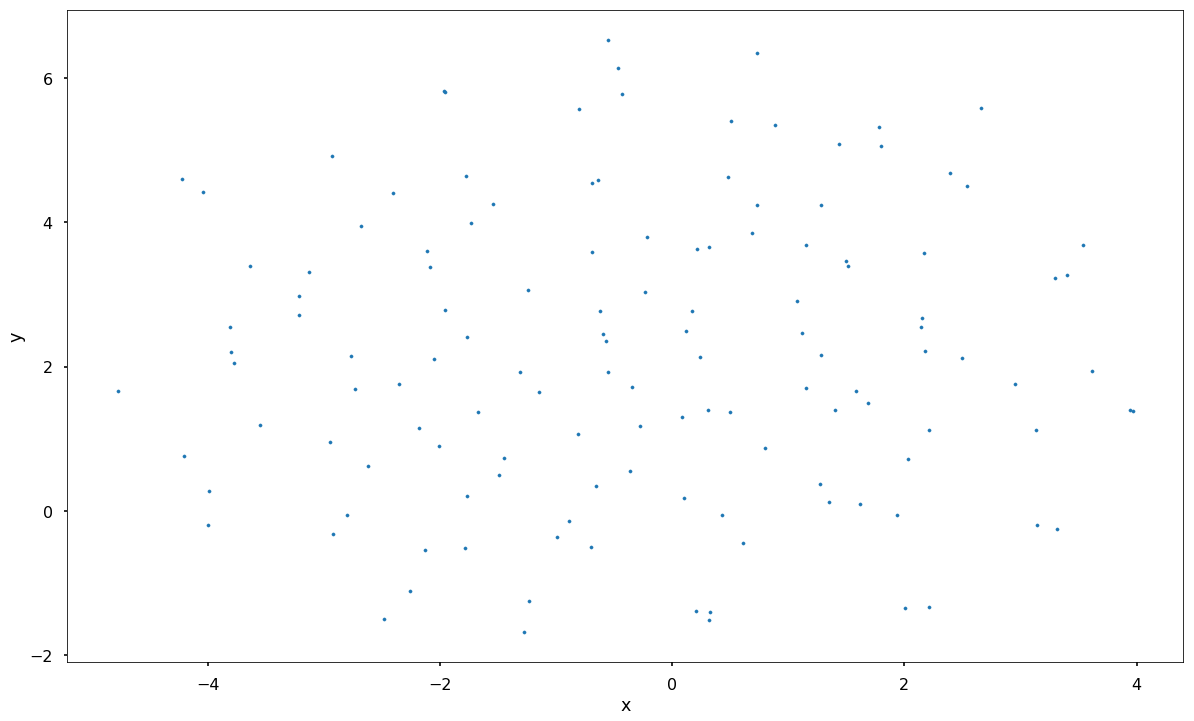

In [190]:
points.plot.scatter("x", "y", s=10, figsize=(20, 12))

**Zoom in to some interesting places**

In [191]:
def plot_region(x_bounds, y_bounds):
    slice = points[
        (x_bounds[0] <= points.x) &
        (points.x <= x_bounds[1]) & 
        (y_bounds[0] <= points.y) &
        (points.y <= y_bounds[1])
    ]
    
    ax = slice.plot.scatter("x", "y", s=35, c=None, figsize=(10, 8))
    for i, point in slice.iterrows():
        ax.text(point.x + 0.005, point.y + 0.005, point.word, fontsize=11)

**Found the House Mottos!**

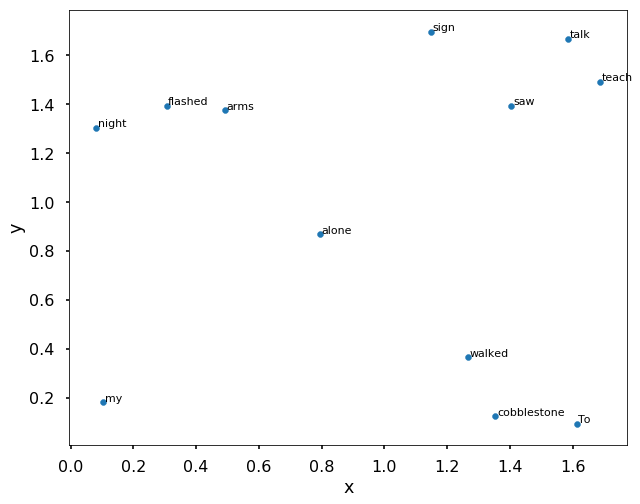

In [193]:
plot_region(x_bounds=(0, 2), y_bounds=(0, 2))

**Can't find anything particularly interesting anymore :(**

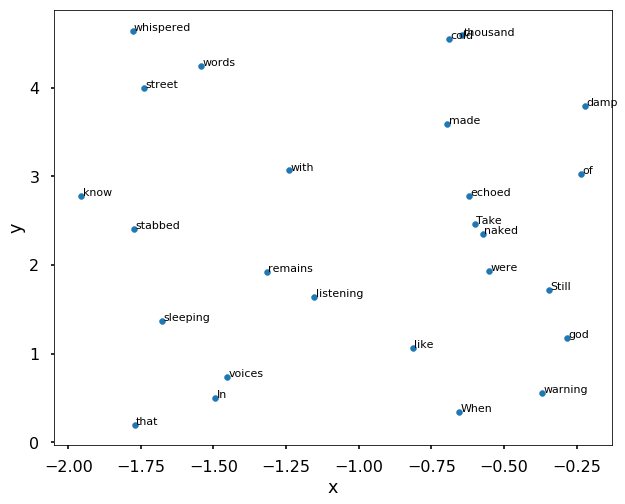

In [195]:
plot_region(x_bounds=(-2, 0), y_bounds=(0, 5))

### Explore semantic similarities between book characters

**Words closest to the given word**

In [153]:
song2vec.wv.most_similar("night")

2018-08-03 13:34:18,418 : INFO : precomputing L2-norms of word weight vectors


[('That', 0.9995754957199097),
 ('split', 0.9995266795158386),
 ('its', 0.9995130300521851),
 ('saw', 0.9995115995407104),
 ('And', 0.9995067715644836),
 ('was', 0.9994991421699524),
 ('like', 0.9994968175888062),
 ('my', 0.9994938373565674),
 ('words', 0.9994784593582153),
 ('vision', 0.9994692206382751)]

In [154]:
song2vec.wv.most_similar("Hello")

[('friend', 0.9997319579124451),
 ('old', 0.999729335308075),
 ('darkness', 0.9997223615646362),
 ('my', 0.9996058344841003),
 ('was', 0.9994905591011047),
 ('That', 0.9994666576385498),
 ('split', 0.999454140663147),
 ('People', 0.9994421601295471),
 ('one', 0.9994351863861084),
 ('Because', 0.9994219541549683)]

In [157]:
song2vec.wv.most_similar("friend")

[('darkness', 0.999733030796051),
 ('Hello', 0.9997320771217346),
 ('old', 0.9996963739395142),
 ('my', 0.9996210336685181),
 ('was', 0.9995285272598267),
 ('People', 0.9994772672653198),
 ('Silence', 0.9994669556617737),
 ('fell', 0.9994582533836365),
 ('like', 0.9994505643844604),
 ('and', 0.9994505047798157)]

**Linear relationships between word pairs**

In [159]:
def nearest_similarity_cosmul(start1, end1, end2):
    similarities = song2vec.wv.most_similar_cosmul(
        positive=[end2, start1],
        negative=[end1]
    )
    start2 = similarities[0][0]
    print("{start1} is related to {end1}, as {start2} is related to {end2}".format(**locals()))
    return start2

In [162]:
nearest_similarity_cosmul("Hello", "darkness", "friend")

Hello is related to darkness, as old is related to friend


'old'